## 0. Setup

In [ ]:
%pip install tqdm
%pip install rich

In [ ]:
import requests
import pandas
from re import sub
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
from time import sleep
import threading
import concurrent.futures
from rich.progress import Progress
from collections import defaultdict

## 1. Utility functions and constants

In [ ]:
API_URL = "https://akasha.cv/api/leaderboards"
INFINITY = float("inf")
MAX_PAGES = 1000  # 1000 pages * 20 entries per page = 20_000 entries


In [ ]:
def snake_case(s):
    """
    Utility function to convert a string to 'this_format'
    """
    return sub(r"_+", "_", sub(r"((?<!^)(?=[A-Z])|[^a-zA-Z0-9])", "_", s)).lower()


In [ ]:
snake_case("Convert ThisValue To snake_case")


'convert_this_value_to_snake_case'

## 2. Fetch the data from Akasha.cv API

In [ ]:
def get_akasha_lb(calculation_id, variant="", lower_bound=INFINITY, retries=10):
    """
    Gets a single page from the Akasha.cv API for the given calculation id and variant,
    applying the given lower bound constraint to the results.
    """
    params = {
        "sort": "calculation.result",
        "order": -1,
        "p": "lt|" + ("Infinity" if lower_bound == INFINITY else str(lower_bound)),
        "calculationId": calculation_id,
        "variant": variant
    }
    try:
        req = requests.get(API_URL, params)
    except:
        for _ in range(retries):
            print(f"Request failed. Retrying")
            sleep(0.5)
            try:
                req = requests.get(API_URL, params)
            except:
                pass
            if req.ok:
                break

    data = req.json()

    # Insert the variant into the data
    for entry in data["data"]:
        entry["variant"] = variant

    return data["data"]


In [ ]:
def get_akasha(calculation_id, variant="", max=100, log=None):
    """
    Gets the data from the Akasha.cv API for the given calculation id and variant,
    with a maximum number of pages.
    """

    results = []

    id = (calculation_id, variant)
    if log:
        log.init(id, max, desc=f"Getting {str(id)}")

    lb = INFINITY
    for i in range(max):
        if log and (i % 10 == 0 or i == max - 1):
            log.update(id, i)
        page = get_akasha_lb(calculation_id, variant, lb)
        if len(page) == 0:
            break

        for p in page:
            results.append(p)
        lb = page[-1]["calculation"]["result"]

    return results


## 3. Transform the JSON data into a DataFrame

In [ ]:
def normalize_akasha_data_row(json):
    """
    Convert a row of the Akasha.cv API response to a flat dictionary
    """
    def get_mainstat(name):
        name = json["artifactObjects"][name]["mainStatKey"] \
            if name in json["artifactObjects"] \
            else None
        return snake_case(name) if name else None

    def get_set(n_piece, index=0):
        """
        Get the n_piece-piece set
        """
        i = 0

        for set_name in json["artifactSets"]:
            set_count = json["artifactSets"][set_name]["count"]
            if set_count == n_piece:
                if i == index:
                    return snake_case(set_name)
                i += 1

        return None

    def get_stats():
        dict = {}
        for stat in json["stats"]:
            dict[snake_case(stat)] = json["stats"][stat]["value"]
        return dict

    flat = {
        "uid": json["uid"],
        "name": snake_case(json["name"]),
        "player": json["owner"]["nickname"],
        "calculation_id": json["calculation"]["id"],
        "md5": json["md5"],
        "variant": json["variant"],
        "calculation_result": json["calculation"]["result"],
        "crit_value": json["critValue"],
        "sands": get_mainstat("EQUIP_SHOES"),
        "goblet": get_mainstat("EQUIP_RING"),
        "circlet": get_mainstat("EQUIP_DRESS"),
        "real_weapon": snake_case(json["weapon"]["name"]),
        "set_2_1": get_set(2),
        "set_2_2": get_set(2, 1),
        "set_4": get_set(4),
        "stats": get_stats()
    }
    return flat


In [ ]:
def normalize_akasha_data(data):
    """
    Convert the Akasha.cv API response to a flat dictionary
    """
    dfs = []
    for row in tqdm(data):
        flat = normalize_akasha_data_row(row)
        flat = pandas.json_normalize(flat)
        dfs.append(flat)

    df = pandas.concat(dfs, ignore_index=True)
    return df


In [ ]:
class LogProgress:
    def __init__(self):
        self.progress = Progress(transient=True)
        self.bars = {}
        self.last = {}
        self.lock = threading.Lock()

    def init(self, index, total, desc=""):
        self.lock.acquire()
        self.bars[index] = self.progress.add_task(desc, total=total)
        self.last[index] = 0
        self.lock.release()

    def update(self, index, value):
        self.lock.acquire()
        with self.progress as progress:
            progress.update(self.bars[index], advance=value - self.last[index])
            self.last[index] = value
        self.lock.release()

## 4. Get the data

In [ ]:
raw_data_requests = [
    ("1000002300", "200er"),  # Xiangling - National Pyronado Vape Avg DMG (The Catch)
]


In [ ]:
def get_akasha_with_args(args, log=None):
    if type(args) != tuple:
        args = (args,)

    if len(args) == 1:
        return get_akasha(args[0], max=MAX_PAGES, log=log)
    elif len(args) == 2:
        return get_akasha(args[0], args[1], max=MAX_PAGES, log=log)


In [ ]:
raw_data = []
log = LogProgress()

def create_task(args):
    return lambda: get_akasha_with_args(args, log=log)

tasks = list(map(create_task, raw_data_requests))

with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
    results = list(executor.map(lambda f: f(), tasks))
    for r in results:
        for entry in r:
            raw_data.append(entry)

Getting ('1000002300', '200er') ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸  99% 0:00:02

In [ ]:
len(raw_data)


20000

In [ ]:
data = normalize_akasha_data(raw_data)
# drop to avoid showing the uid in the output


100%|██████████| 20000/20000 [00:26<00:00, 767.31it/s]


In [ ]:
# Transformed data is saved to a CSV file so it can
# be recovered later if you don't want to re-download
with open("akasha_data.csv", "w") as f:
    f.write(data.to_csv())
    f.close()


In [ ]:
# To recover the data from the local CSV file,
# Omit all the download code above (4th section) and
# run only the following:
# data = pandas.read_csv("akasha_data.csv")


In [ ]:
data["variant"] = data["variant"].fillna("None")


In [ ]:
data.columns

Index(['uid', 'name', 'player', 'calculation_id', 'md5', 'variant',
       'calculation_result', 'crit_value', 'sands', 'goblet', 'circlet',
       'real_weapon', 'set_2_1', 'set_2_2', 'set_4', 'stats.max_hp',
       'stats.atk', 'stats.def', 'stats.elemental_mastery',
       'stats.energy_recharge', 'stats.healing_bonus', 'stats.crit_rate',
       'stats.crit_damage', 'stats.pyro_damage_bonus'],
      dtype='object')

In [ ]:
data

,uid,name,player,calculation_id,md5,variant,calculation_result,crit_value,sands,goblet,...,artifact.elemental_mastery,artifact.crit_d_m_g,artifact.a_t_k_,artifact.crit_r_a_t_e,artifact.energy_recharge,artifact.h_p_,artifact.flat_d_e_f,artifact.d_e_f_,artifact.flat_a_t_k,artifact.flat_h_p
0,601886273,xiangling,Zuko火,1000002300,1979a941902b1b38d7c6703af23d6eb4,200er,50647.959362,245.639997,elemental_mastery,pyro_d_m_g_bonus,...,72.270000,115.000000,30.910001,34.220002,34.980003,5.830001,18.520001,NaN,NaN,NaN
1,863514740,xiangling,Poseidon,1000002300,f32be9dd34b8485d849c120013ab691d,200er,49370.390447,253.419996,elemental_mastery,pyro_d_m_g_bonus,...,NaN,114.999999,32.060001,38.110002,35.630003,4.080001,16.200001,14.58,19.450001,NaN
2,607713603,xiangling,Vitor2710,1000002300,ea27137929da5f6c7be70315c753159e,200er,49227.093851,245.669998,elemental_mastery,pyro_d_m_g_bonus,...,86.249999,66.810001,13.980000,58.330001,40.160003,4.080001,23.150000,NaN,13.620000,NaN
3,824316661,xiangling,JackyTan,1000002300,0d2d7ae20438245e92eddaf97af3b1a4,200er,49182.150092,233.989998,elemental_mastery,pyro_d_m_g_bonus,...,46.620001,96.350001,41.970003,37.720002,38.210002,NaN,NaN,NaN,13.620001,239.000001
4,600451889,xiangling,Moca,1000002300,2267b96cbe7802a3e46191f83e7ad7d2,200er,49147.469285,235.539996,elemental_mastery,pyro_d_m_g_bonus,...,104.899999,101.780000,20.400002,35.780002,44.690004,NaN,NaN,NaN,NaN,298.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,762512680,xiangling,nameless_man,1000002300,db86b20785f383ba52466c9b99474d48,200er,38453.725448,227.789996,energy_recharge,pyro_d_m_g_bonus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19996,iml1xs,xiangling,nameless_man,1000002300,9a186087a138871a083bdd60bcd9628e,200er,38453.724214,227.789997,energy_recharge,pyro_d_m_g_bonus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19997,802273627,xiangling,Drifter,1000002300,182deed9d31c7c04ab40182b471b8132,200er,38453.661036,181.139999,elemental_mastery,pyro_d_m_g_bonus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19998,708288195,xiangling,molo,1000002300,9a8c5a98eb894fa7abdfe9a231e5aee6,200er,38453.509895,174.909999,elemental_mastery,pyro_d_m_g_bonus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def get_substats(uid, md5, retries=10):
    url = f"https://akasha.cv/api/artifacts/{uid}/{md5}"
    response = None

    try:
        response = requests.get(url)
    except Exception as e:
        for _ in range(retries):
            print(f"Request failed. Retrying... ({_+1}/{retries})")
            sleep(0.5)
            try:
                response = requests.get(url)
            except Exception as e:
                pass
            if response and response.ok:
                break

    if response.status_code == 200:
      data = response.json().get('data', [])
      substats_agg = defaultdict(float)
      for record in data:
        substats = record.get('substats', {})
        for key, value in substats.items():
          substats_agg[key] += value
      return substats_agg
    return defaultdict(float)

650it [01:55,  5.91it/s]

Request failed. Retrying... (1/10)


809it [02:24,  4.64it/s]

Request failed. Retrying... (1/10)


5183it [15:28,  4.81it/s]

Request failed. Retrying... (1/10)


8524it [25:24,  5.36it/s]

Request failed. Retrying... (1/10)


8692it [25:55,  5.59it/s]


KeyboardInterrupt: 

In [ ]:
# Function to process a single row
def process_row(index, row):
    uid = row['uid']
    md5 = row['md5']
    substats = get_substats(uid, md5)

    updates = {}
    for stat, val in substats.items():
        name = "artifact." + snake_case(stat)
        updates[name] = val
    return index, updates


# Initialize a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
    futures = []
    for index, row in tqdm(data.iterrows()):
        futures.append(executor.submit(process_row, index, row))

    # Process the results as they complete
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        index, updates = future.result()
        for key, value in updates.items():
            data.at[index, key] = value

  1%|          | 199/20000 [00:00<00:45, 434.39it/s]

KeyboardInterrupt



## 5. Analyse the data

In [ ]:
# Will split the data into groups by calculation_id and variant
groups = data.groupby(["name", "calculation_id", "variant"])
groups["calculation_result"].describe()


,,,count,mean,std,min,25%,50%,75%,max
name,calculation_id,variant,,,,,,,,
xiangling,1000002300,200er,20000.0,40648.440848,1830.964349,38453.327351,39219.471391,40169.837703,41635.164041,50647.959362


### 5.1. Utility functions

In [ ]:
def plot_sub(df, key_x, key_y, label_x="X", label_y="Y", title="scatterplot", mapfn=None):
    return (df[key_x], df[key_y], label_x, label_y, title, mapfn)


def plot_scatter(data_list, cols, title=""):
    """
    Plot multiple scatter plots with KDE density color maps in a grid.

    Args:
    data_list (list of tuples): List of (x, y, label_x, label_y, title, mapfn)
    data pairs for each subplot. The mapfn is called as `mapfn(fig, ax)` after
    the scatter plot is configured.

    cols (int): Number of columns in the grid layout.

    Returns:
    None
    """
    rows = len(data_list) // cols + (len(data_list) % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    fig.subplots_adjust(hspace=0.5)

    fig.suptitle(title, fontsize=16)

    for i, (x, y, label_x, label_y, title, mapfn) in enumerate(data_list):
        row = i // cols
        col = i % cols

        ax = axes[row, col] if rows > 1 else axes[col]

        stack = np.vstack([x, y])
        density = gaussian_kde(stack)(stack)
        # Scatter plot
        plot = ax.scatter(x=x, y=y, s=5, c=density)

        ax.set_xlabel(label_x)
        ax.set_ylabel(label_y)
        ax.set_title(title)

        if mapfn:
            mapfn(fig, ax, plot)

    # Remove empty subplots
    for i in range(len(data_list), rows * cols):
        row = i // cols
        col = i % cols
        fig.delaxes(axes[row, col] if rows > 1 else axes[col])

    fig.tight_layout()
    plt.show()


### 5.2. Correlation between crit value and final damage

In [ ]:
def get_anotation_fn(df):
    corr = df["crit_value"].corr(df["calculation_result"])

    def add_anotation(_, ax, plot):
        # Correlation coefficient
        ax.annotate(f'correlation = {corr:.4f}',
                    (0.05, 0.95),
                    xycoords='axes fraction',
                    ha='left',
                    va='top')

        plt.colorbar(plot, label='Density (KDE)')
    return add_anotation


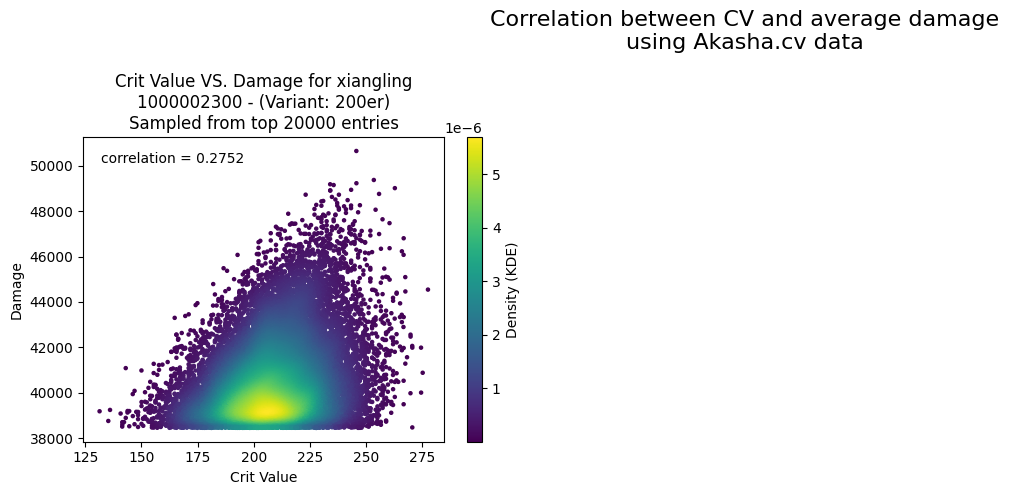

In [ ]:
plots = []
for (name, calculation_id, variant), group in groups:

    corr = group["crit_value"].corr(group["calculation_result"])

    plots.append(plot_sub(
        group,
        "crit_value",
        "calculation_result",
        label_x="Crit Value",
        label_y="Damage",
        title=f"Crit Value VS. Damage for {name}\n{calculation_id} - (Variant: {variant})\nSampled from top {len(group)} entries",
        mapfn=get_anotation_fn(group)
    ))
plot_scatter(
    plots, 3, "Correlation between CV and average damage\nusing Akasha.cv data")
